# Angled average spectrum of 2D flow
- Spectrum of Vorticity $\omega$ and Streamfunction $\psi$
- Energy (TKE) Spectrum $E(k)$
- Enstrophy Spectrum $Z(k)$

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# scipy.io.loadmat is used for reading MATLAB mat files
from scipy.io import loadmat

# Importing specific functions from the py2d library

# spectrum_angled_average: Computes the angled average spectrum of a 2D field
# TKE_angled_average: Computes the angled average turbulent kinetic energy of a 2D field
# enstrophy_angled_average: Computes the angled average enstrophy of a 2D field
from py2d.spectra import spectrum_angled_average, TKE_angled_average, enstrophy_angled_average, spectrum_zonal_average

from py2d.apriori_analysis import energy, enstrophy, energyTransfer, enstrophyTransfer

# initialize_wavenumbers_rfft2: Initializes the wavenumbers for a 2D field
from py2d.initialize import initialize_wavenumbers_rfft2

# Omega2Psi: Converts vorticity to stream function in a 2D field
from py2d.convert import Omega2Psi, Psi2UV

from py2d.filter import filter2D

### Angled average Spectrum of Vorticity $\omega$ and Streamfunction $\psi$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


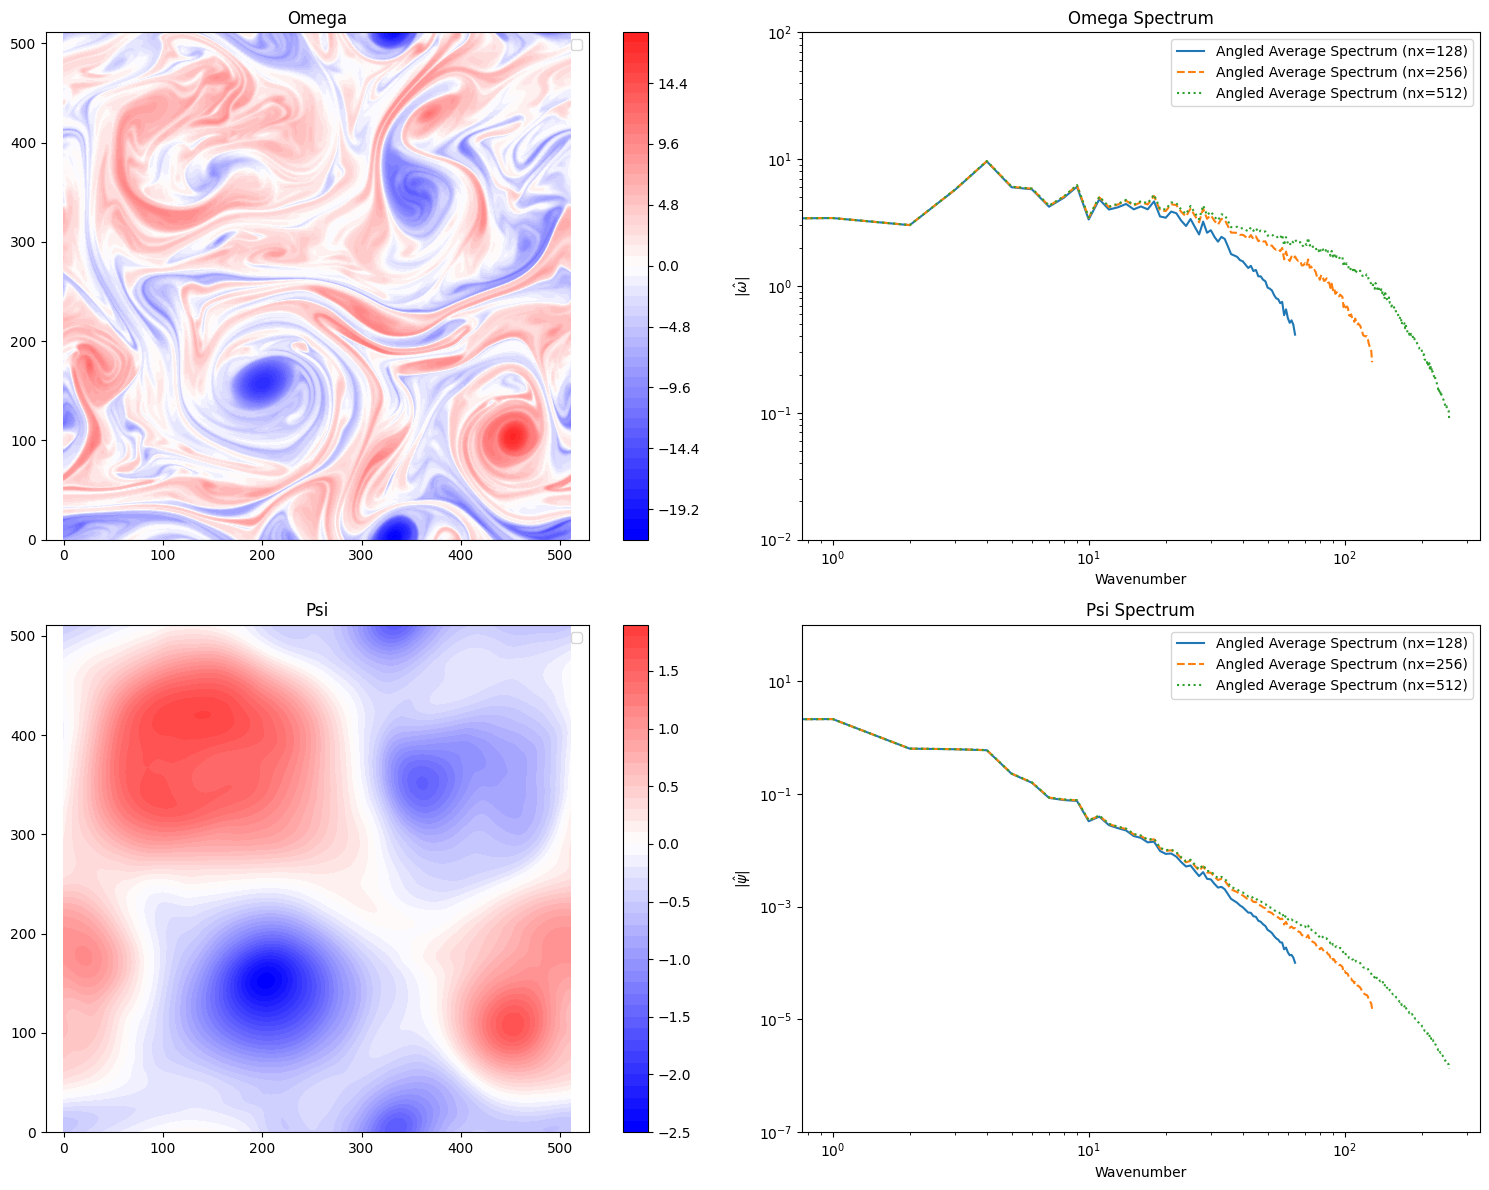

In [10]:
# define the line styles to be used in the plots
line_styles = ['-', '--', ':']
# define the grid size of the domain for the calculations
nx_values = [128, 256, 512]

# define the domain size for the calculations
Lx = 2*np.pi  

# Create a figure with 4 subplots arranged in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# For each grid size in nx_values
for i, nx in enumerate(nx_values):
    # create the file name string
    filename = '../data/ICs/NX' + str(nx) + '/1.mat'
    # initialize the wavenumbers using the initialize_wavenumbers_rfft2 function
    Kx, Ky, Kabs, Ks, invKsq = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')

    # load the data from the file
    data = loadmat(filename)
    # get the Omega data from the file
    Omega = data['Omega']
    # calculate Psi from Omega using the Omega2Psi function
    Psi = Omega2Psi(Omega, invKsq=invKsq)

    # Calculate the absolute value of the Fourier transform of Omega
    Omega_abs_hat = np.sqrt(np.fft.fft2(Omega)*np.conj(np.fft.fft2(Omega)))
    # Calculate the spectrum using the spectrum_angled_average function
    spectrum_angled_Omega, wavenumbers_angled_Omega = spectrum_angled_average(Omega_abs_hat, spectral=True)


    # Calculate the absolute value of the Fourier transform of Psi
    Psi_abs_hat = np.sqrt(np.fft.fft2(Psi)*np.conj(np.fft.fft2(Psi)))
    # Calculate the spectrum using the spectrum_angled_average function
    spectrum_angled_Psi, wavenumbers_angled_Psi = spectrum_angled_average(Psi_abs_hat, spectral=True)

    # Create a log-log plot of the spectrum of Omega
    axs[0, 1].loglog(wavenumbers_angled_Omega, spectrum_angled_Omega, line_styles[i], label=f'Angled Average Spectrum (nx={nx})')
    axs[0, 1].set_title('Omega Spectrum')  # set the title of the plot
    axs[0, 1].set_xlabel('Wavenumber')  # set the x-axis label
    axs[0, 1].set_ylabel(r'$|\hat{\omega}|$')  # set the y-axis label
    axs[0, 1].set_ylim([1e-2, 1e2])  # set the y-axis limit

    # Create a log-log plot of the spectrum of Psi
    axs[1, 1].loglog(wavenumbers_angled_Psi, spectrum_angled_Psi, line_styles[i], label=f'Angled Average Spectrum (nx={nx})')
    axs[1, 1].set_title('Psi Spectrum')  # set the title of the plot
    axs[1, 1].set_xlabel('Wavenumber')  # set the x-axis label
    axs[1, 1].set_ylabel(r'$|\hat{\psi}|$')  # set the y-axis label
    axs[1, 1].set_ylim([1e-7, 1e2])  # set the y-axis limit

# Create a filled contour plot of Omega
vmax = np.max(np.abs(Omega))  # get the maximum value of Omega
vmin = -vmax  # set the minimum value of Omega to be the negative of the maximum value

contour_Omega = axs[0, 0].contourf(Omega, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(contour_Omega, ax=axs[0, 0])  # add a colorbar to the plot
axs[0, 0].set_title('Omega')  # set the title of the plot
axs[0, 0].axis('equal')  # set the aspect ratio of the plot to 1

# Create a filled contour plot of Psi
vmax = np.max(np.abs(Psi))  # get the maximum value of Psi
vmin = -vmax  # set the minimum value of Psi to be the negative of the maximum value

contour_Psi = axs[1, 0].contourf(Psi, cmap='bwr', levels=50,  vmax=vmax, vmin=vmin)
plt.colorbar(contour_Psi, ax=axs[1, 0])  # add a colorbar to the plot
axs[1, 0].set_title('Psi')  # set the title of the plot
axs[1, 0].axis('equal')  # set the aspect ratio of the plot to 1

# Add a legend to each subplot
for ax in axs.flat:
    ax.legend()

# Adjust the layout of the subplots to fit the figure
fig.tight_layout()
# Show the figure
plt.show()


### Zonal spectra

0.9480666520229523 5.369969636765059 (257,)


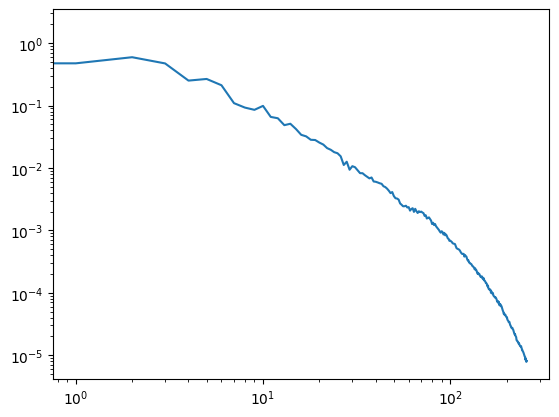

In [11]:
from py2d.convert import Psi2UV

U, V = Psi2UV(Psi, Kx=Kx, Ky=Ky)
E = (U**2 + V**2)/2

spectrum, wavenumber = spectrum_zonal_average(E)

print(np.mean(E), np.sum(spectrum), spectrum.shape)

plt.loglog(spectrum)

In [5]:
def get_avg_spectra_leadtime(dataloader, model, var=0):
    """dims of pds: [n_steps, spectra]"""

    pds_pred, pds_tar = [], []
    for i, batch in enumerate(dataloader):

        print(f'Iter: {i}')
        inputs, target = batch[0].to(device), batch[1].to(device)
        ic = inputs[0].unsqueeze(dim=0)
        n_steps = inputs.shape[0]

        pred = n_step_prediction(model, ic, n_steps)
        pred = pred[1:]
        print(f'pred.shape: {pred.shape}')

        # Calculate power spectra for each lead time
        specs_pred, specs_tar = [], []
        for j in range(n_steps):
            nth_pred = pred[j, var, 0, :, :].transpose(-1, -2).squeeze()    # flip image so that u-jets are horizontal
            nth_tar = target[j, var, 0, :, :].transpose(-1, -2).squeeze()
            nth_pred = nth_pred.cpu().numpy()
            nth_tar = nth_tar.cpu().numpy()

            f, Pxx_pred = welch(nth_pred, scaling='density', axis=-1)
            _, Pxx_tar = welch(nth_tar, scaling='density', axis=-1)

            print(f'Pxx_pred.shape: {Pxx_pred.shape}')

            Pxx_pred = Pxx_pred.mean(axis=0)
            Pxx_tar = Pxx_tar.mean(axis=0)

            specs_pred.append(Pxx_pred)
            specs_tar.append(Pxx_tar)

        specs_pred = np.stack(specs_pred, axis=0)
        specs_tar = np.stack(specs_tar, axis=0)

        pds_pred.append(specs_pred)
        pds_tar.append(specs_tar)

    pds_pred = np.stack(pds_pred, axis=0)
    pds_pred = pds_pred.mean(axis=0)
    pds_tar = np.stack(pds_tar, axis=0)
    pds_tar = pds_tar.mean(axis=0)

    return pds_pred, pds_tar[0, :], f

### Energy (TKE) $E(k)$ and Enstrophy $Z(k)$ Spectrum

For nx=128:
Enstrophy from physical space: 8.903532921364818
Integral of enstrophy spectrum: 8.902451769304461

Energy from physical space: 0.9409915628893168
Integral of energy spectrum: 0.940991331310203

-------------------------------
For nx=256:
Enstrophy from physical space: 9.73043017977825
Integral of enstrophy spectrum: 9.72998143347469

Energy from physical space: 0.9465712822685571
Integral of energy spectrum: 0.9465712578991947

-------------------------------
For nx=512:
Enstrophy from physical space: 10.175551879975895
Integral of enstrophy spectrum: 10.175511453081445

Energy from physical space: 0.9480666520229525
Integral of energy spectrum: 0.9480666514640173

-------------------------------


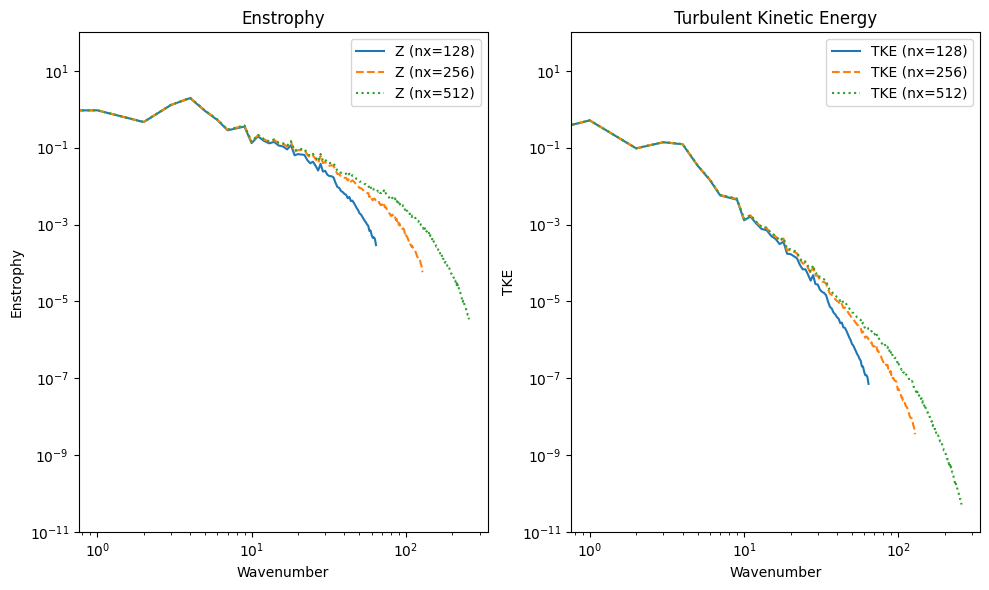

In [6]:
# define the line styles to be used in the plots
line_styles = ['-', '--', ':']
# define the grid size of the domain for the calculations
nx_values = [128, 256, 512]

# define the domain size for the calculations
Lx = 2*np.pi  

# Create a figure with 2 subplots arranged in a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# For each grid size in nx_values
for i, nx in enumerate(nx_values):
    # create the file name string
    filename = '../data/ICs/NX' + str(nx) + '/1.mat'
    # initialize the wavenumbers using the initialize_wavenumbers_rfft2 function
    Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')

    # load the data from the file
    data = loadmat(filename)
    # get the Omega data from the file
    Omega = data['Omega']
    # calculate Psi from Omega using the Omega2Psi function
    Psi = Omega2Psi(Omega, invKsq=invKsq)

    # calculate enstrophy Z using the enstrophy_angled_average function
    Z, wavenumber_TKE = enstrophy_angled_average(Omega, spectral=False)
    # calculate turbulent kinetic energy TKE using the TKE_angled_average function
    TKE, wavenumber_Z = TKE_angled_average(Psi, Omega, spectral=False)

    # Create a log-log plot of the enstrophy
    axs[0].loglog(wavenumber_Z, Z, line_styles[i], label=f'Z (nx={nx})')
    axs[0].set_title('Enstrophy')  # set the title of the plot
    axs[0].set_xlabel('Wavenumber')  # set the x-axis label
    axs[0].set_ylabel('Enstrophy')  # set the y-axis label
    axs[0].set_ylim([1e-11, 1e2])  # set the y-axis limit

    # Create a log-log plot of the turbulent kinetic energy
    axs[1].loglog(wavenumber_TKE, TKE, line_styles[i], label=f'TKE (nx={nx})')
    axs[1].set_title('Turbulent Kinetic Energy')  # set the title of the plot
    axs[1].set_xlabel('Wavenumber')  # set the x-axis label
    axs[1].set_ylabel('TKE')  # set the y-axis label
    axs[1].set_ylim([1e-11, 1e2])  # set the y-axis limit

    # Validation of the spectra
    # Area under the spectrum should be equal to mean in the physical spectrum

    enstrophy_physical = enstrophy(Omega, spectral = False)
    energy_physical = energy(Psi, Omega, spectral = False)

    integral_enstrophy_spectrum = np.sum(Z)
    integral_energy_spectrum = np.sum(TKE)

    print(f"For nx={nx}:")
    print(f"Enstrophy from physical space: {enstrophy_physical}")
    print(f"Integral of enstrophy spectrum: {integral_enstrophy_spectrum}\n")
    
    print(f"Energy from physical space: {energy_physical}")
    print(f"Integral of energy spectrum: {integral_energy_spectrum}\n")
    print("-------------------------------")


# Add a legend to each subplot
for ax in axs.flat:
    ax.legend()

# Adjust the layout of the subplots to fit the figure
fig.tight_layout()
# Show the figure
plt.show()



### Energy Transfer $P_{\tau}(k)$ and Enstrophy Transfer $P_Z(k)$ Spectrum

For N_LES: 512, filter: gaussian, coarseGrain: spectral
Energy Transfer from physical space: -1.1423159975731346e-05
Integral of energy transfer spectrum Tau: -1.1436762239132246e-05
Integral of energy transfer spectrum PiOmega: -1.1436732869832717e-05

energy Transfer from physical space (positive): 2.2641970617096274e-05
Integral of energy transfer spectrum Tau (positive): 0.00025967618332390773
Integral of energy transfer spectrum PiOmega (positive): 0.000259676212693266

energy Transfer from physical space (negative): -3.6777866188236246e-05
Integral of energy transfer spectrum Tau (negative): -0.00027111294556304003
Integral of energy transfer spectrum PiOmega (negative): -0.00027111294556309874

-------------------------------
Enstrophy Trnsfer from physical space: 0.36896834683458896
Integral of enstrophy Transfer spectrum Sigma: 0.3679630318382069
Integral of enstrophy Transfer spectrum PiOmega: 0.36800687629218853

Integral of k**2 energy Transfer spectrum Tau: 0.3676586045236

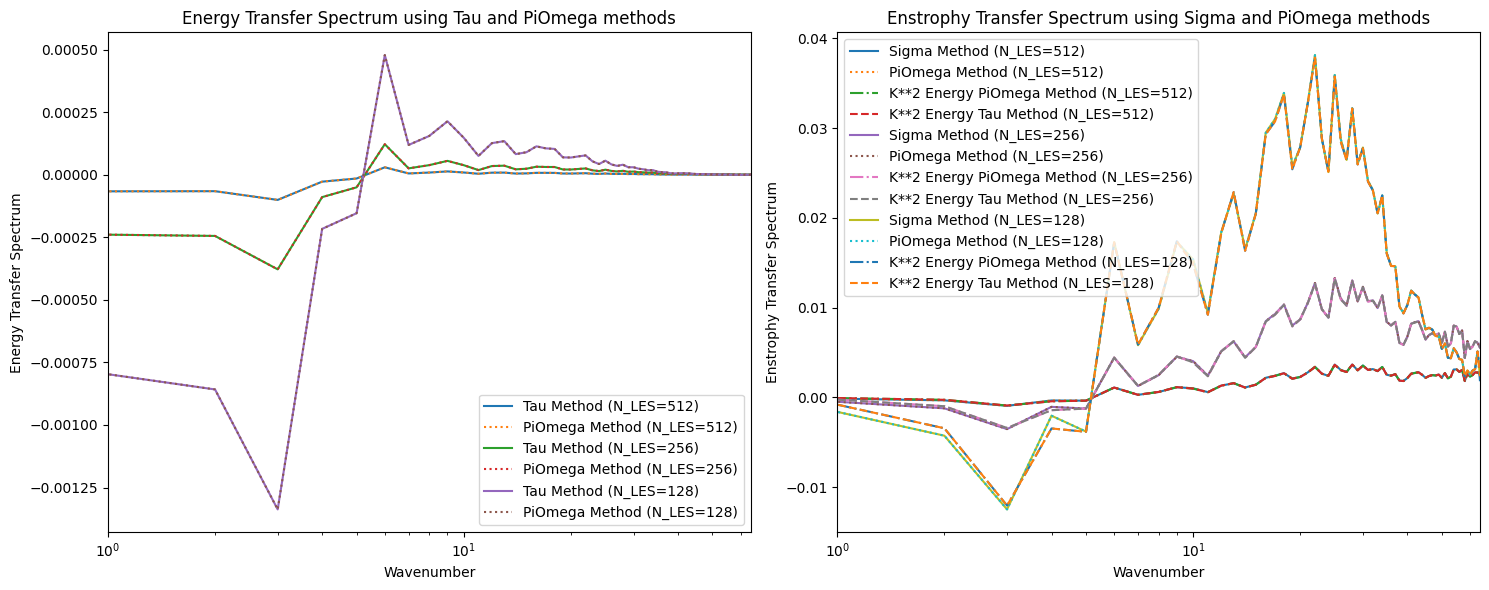

In [7]:
from py2d.SGSterms import Tau, PiUV, PiOmega, Sigma
from py2d.convert import Omega2Psi, Psi2UV, Tau2PiOmega
from py2d.spectra import energyTransfer_spectra, enstrophyTransfer_spectra
from py2d.derivative import derivative

# define the line styles to be used in the plots
line_styles = ['-', '--', ':']
# define the grid size of the domain for the calculations
N_LES_values = [512, 256, 128]

dealias = True

Lx, Ly = 2*np.pi, 2*np.pi
nx=1024

filter = 'gaussian'
coarseGrain = 'spectral'

filename = '../data/ICs/NX' + str(nx) + '/1.mat'

Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')

# Create a 2-panel figure
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

for idx, N_LES in enumerate(N_LES_values):

    Delta = 2*Lx/N_LES
    A = 1/Delta**2

    if coarseGrain == None:
        Kx_coarse, Ky_coarse, Kabs_coarse, Ksq_coarse, invKsq_coarse = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')
    elif coarseGrain == 'spectral':
        Kx_coarse, Ky_coarse, Kabs_coarse, Ksq_coarse, invKsq_coarse = initialize_wavenumbers_rfft2(N_LES, N_LES, Lx, Lx, INDEXING='ij')

    # load the data from the file
    data = loadmat(filename)
    # get the Omega data from the file
    Omega = data['Omega']

    Psi = Omega2Psi(Omega, invKsq=invKsq)
    U, V = Psi2UV(Psi, Kx, Ky)

    Tau11, Tau12, Tau22 = Tau(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)
    Sigma1, Sigma2 = Sigma(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)
    PiOmegaa = PiOmega(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)

    U_f = filter2D(U, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
    V_f = filter2D(V, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
    Psi_f = filter2D(Psi, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
    Omega_f = filter2D(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)

    # Compute energy and enstrophy spectra
    energy_spectrumTau, k_energy_Tau = energyTransfer_spectra(U=U_f, V=V_f, Tau11=Tau11, Tau12=Tau12, Tau22=Tau22, Kx=Kx_coarse, Ky=Ky_coarse,method='Tau')
    energy_spectrumPiOmega, k_energy_PiOmega = energyTransfer_spectra(Psi=Psi_f, PiOmega=PiOmegaa, Kx=Kx_coarse,Ky=Ky_coarse,method='PiOmega')

    enstrophy_spectrumSigma, k_enstrophy_Sigma = enstrophyTransfer_spectra(Omega=Omega_f, Sigma1=Sigma1, Sigma2=Sigma2, Kx=Kx_coarse, Ky=Ky_coarse,method='Sigma')
    PiOmegaa = Tau2PiOmega(Tau11, Tau12, Tau22, Kx_coarse, Ky_coarse, spectral=False)
    enstrophy_spectrumPiOmega, k_enstrophy_PiOmega = enstrophyTransfer_spectra(Omega=Omega_f, PiOmega=PiOmegaa, Kx=Kx_coarse, Ky=Ky_coarse,method='PiOmega')

    # Plot energy transfer spectrum
    axs[0].semilogx(k_energy_Tau, energy_spectrumTau, label=f'Tau Method (N_LES={N_LES})')
    axs[0].semilogx(k_energy_PiOmega, energy_spectrumPiOmega, ':', label=f'PiOmega Method (N_LES={N_LES})')
    axs[0].set_xlabel('Wavenumber')
    axs[0].set_ylabel('Energy Transfer Spectrum')
    axs[0].legend()
    axs[0].set_title('Energy Transfer Spectrum using Tau and PiOmega methods')
    axs[0].set_xlim(1, (k_energy_Tau[-1]))
    # axs[0].grid(True, which="both", ls="--")
    # axs[0].set_ylim(1e-7, 1e-1)

    # Plot enstrophy transfer spectrum
    axs[1].semilogx(k_enstrophy_Sigma, enstrophy_spectrumSigma, label=f'Sigma Method (N_LES={N_LES})')
    axs[1].semilogx(k_enstrophy_PiOmega, enstrophy_spectrumPiOmega, ':', label=f'PiOmega Method (N_LES={N_LES})')
    axs[1].semilogx(k_enstrophy_PiOmega,(k_enstrophy_PiOmega**2)* energy_spectrumPiOmega, '-.', label=f'K**2 Energy PiOmega Method (N_LES={N_LES})')
    axs[1].semilogx(k_enstrophy_PiOmega,(k_enstrophy_PiOmega**2)* energy_spectrumTau, '--', label=f'K**2 Energy Tau Method (N_LES={N_LES})')
    axs[1].set_xlabel('Wavenumber')
    axs[1].set_ylabel('Enstrophy Transfer Spectrum')
    axs[1].legend()
    axs[1].set_title('Enstrophy Transfer Spectrum using Sigma and PiOmega methods')
    axs[1].set_xlim(1, (k_enstrophy_Sigma[-1]))
    # axs[1].grid(True, which="both", ls="--")
    # axs[1].set_ylim(1e-3, 1e0)

    enstrophyTransfer_physical = enstrophyTransfer(Omega_f, Sigma1, Sigma2, Kx_coarse, Ky_coarse)
    energyTransfer_physical = energyTransfer(U_f, V_f, Tau11, Tau12, Tau22, Kx_coarse, Ky_coarse)

    mean_enstrophyTransfer_physical = np.mean(enstrophyTransfer_physical)
    mean_energyTransfer_physical = np.mean(energyTransfer_physical)

    mean_pos_enstrophyTransfer_physical = np.mean(enstrophyTransfer_physical[enstrophyTransfer_physical>0])
    mean_pos_energyTransfer_physical= np.mean(energyTransfer_physical[energyTransfer_physical>0])

    mean_neg_enstrophyTransfer_physical = np.mean(enstrophyTransfer_physical[enstrophyTransfer_physical<0])
    mean_neg_energyTransfer_physical = np.mean(energyTransfer_physical[energyTransfer_physical<0])

    # scale_factor = 


    integral_energyTransfer_spectrumTau = np.sum(energy_spectrumTau)
    integral_energyTransfer_spectrumPiOmega = np.sum(energy_spectrumPiOmega)
    integral_enstrophyTransfer_spectrumSigma = np.sum(enstrophy_spectrumSigma)
    integral_enstrophyTransfer_spectrumPiOmega = np.sum(enstrophy_spectrumPiOmega)
    integral_Ksq_energyTransfer_spectrumTau = np.sum((k_energy_Tau**2)*energy_spectrumTau)
    integral_Ksq_energyTransfer_spectrumPiOmega = np.sum((k_energy_PiOmega**2)*energy_spectrumPiOmega)

    integral_pos_energyTransfer_spectrumTau = np.sum(energy_spectrumTau[energy_spectrumTau>0])
    integral_pos_energyTransfer_spectrumPiOmega = np.sum(energy_spectrumPiOmega[energy_spectrumPiOmega>0])
    integral_pos_enstrophyTransfer_spectrumSigma = np.sum(enstrophy_spectrumSigma[enstrophy_spectrumSigma>0])
    integral_pos_enstrophyTransfer_spectrumPiOmega = np.sum(enstrophy_spectrumPiOmega[enstrophy_spectrumPiOmega>0])

    integral_neg_energyTransfer_spectrumTau = np.sum(energy_spectrumTau[energy_spectrumTau<0])
    integral_neg_energyTransfer_spectrumPiOmega = np.sum(energy_spectrumPiOmega[energy_spectrumPiOmega<0])
    integral_neg_enstrophyTransfer_spectrumSigma = np.sum(enstrophy_spectrumSigma[enstrophy_spectrumSigma<0])
    integral_neg_enstrophyTransfer_spectrumPiOmega = np.sum(enstrophy_spectrumPiOmega[enstrophy_spectrumPiOmega<0])

    print(f"For N_LES: {N_LES}, filter: {filter}, coarseGrain: {coarseGrain}")

    print(f"Energy Transfer from physical space: {mean_energyTransfer_physical}")
    print(f"Integral of energy transfer spectrum Tau: {integral_energyTransfer_spectrumTau}")
    print(f"Integral of energy transfer spectrum PiOmega: {integral_energyTransfer_spectrumPiOmega}\n")

    print(f"energy Transfer from physical space (positive): {mean_pos_energyTransfer_physical}")
    print(f"Integral of energy transfer spectrum Tau (positive): {integral_pos_energyTransfer_spectrumTau}")
    print(f"Integral of energy transfer spectrum PiOmega (positive): {integral_pos_energyTransfer_spectrumPiOmega}\n")

    print(f"energy Transfer from physical space (negative): {mean_neg_energyTransfer_physical}")
    print(f"Integral of energy transfer spectrum Tau (negative): {integral_neg_energyTransfer_spectrumTau}")
    print(f"Integral of energy transfer spectrum PiOmega (negative): {integral_neg_energyTransfer_spectrumPiOmega}\n")

    print("-------------------------------")

    print(f"Enstrophy Trnsfer from physical space: {mean_enstrophyTransfer_physical}")
    print(f"Integral of enstrophy Transfer spectrum Sigma: {integral_enstrophyTransfer_spectrumSigma}")
    print(f"Integral of enstrophy Transfer spectrum PiOmega: {integral_enstrophyTransfer_spectrumPiOmega}\n")
    print(f"Integral of k**2 energy Transfer spectrum Tau: {integral_Ksq_energyTransfer_spectrumTau}")
    print(f"Integral of k**2 energy Transfer spectrum PiOmega: {integral_Ksq_energyTransfer_spectrumPiOmega}\n")

    print(f"Enstrophy Trnsfer from physical space (positive): {mean_pos_enstrophyTransfer_physical}")
    print(f"Integral of enstrophy Transfer spectrum Sigma (positive): {integral_pos_enstrophyTransfer_spectrumSigma}")
    print(f"Integral of enstrophy Transfer spectrum PiOmega (positive): {integral_pos_enstrophyTransfer_spectrumPiOmega}\n")

    print(f"Enstrophy Trnsfer from physical space (negative): {mean_neg_enstrophyTransfer_physical}")
    print(f"Integral of enstrophy Transfer spectrum Sigma (negative): {integral_neg_enstrophyTransfer_spectrumSigma}")
    print(f"Integral of enstrophy Transfer spectrum PiOmega (negative): {integral_neg_enstrophyTransfer_spectrumPiOmega}\n")

    print("-------------------------------")


plt.tight_layout()
plt.show()

### Energy Transfer $P_{\tau}$ and Enstrophy Transfer $P_Z$ Contour

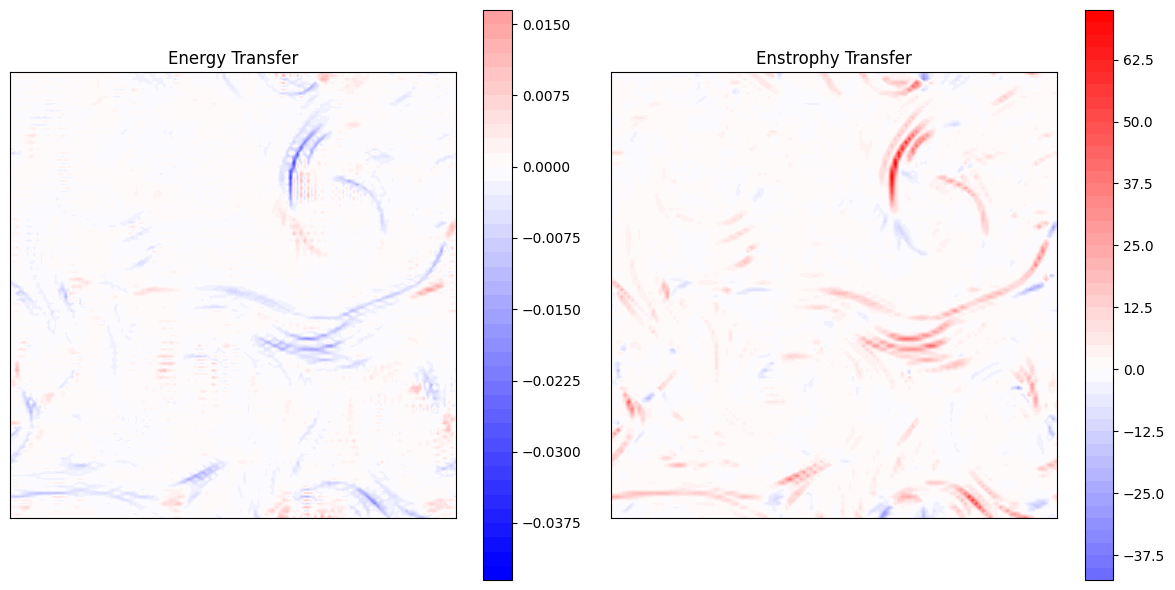

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Energy Transfer
vmax_energy = np.max(np.abs(energyTransfer_physical))
vmin_energy = -vmax_energy

contour_energy = axs[0].contourf(energyTransfer_physical, cmap='bwr', levels=50, vmax=vmax_energy, vmin=vmin_energy)
cb = plt.colorbar(contour_energy, ax=axs[0])
axs[0].set_title('Energy Transfer')
axs[0].set_aspect('equal', 'box')  # Ensure equal box sizes
axs[0].set_xticks([])  # Remove x ticks
axs[0].set_yticks([])  # Remove y ticks

# Enstrophy Transfer
vmax_enstrophy = np.max(np.abs(enstrophyTransfer_physical))
vmin_enstrophy = -vmax_enstrophy

contour_enstrophy = axs[1].contourf(enstrophyTransfer_physical, cmap='bwr', levels=50, vmax=vmax_enstrophy, vmin=vmin_enstrophy)
cb = plt.colorbar(contour_enstrophy, ax=axs[1])
axs[1].set_title('Enstrophy Transfer')
axs[1].set_aspect('equal', 'box')  # Ensure equal box sizes
axs[1].set_xticks([])  # Remove x ticks
axs[1].set_yticks([])  # Remove y ticks

plt.tight_layout()
plt.show()
